# Exploration of Butterworth Filters

In [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8311494/) paper, the network consists of two CNN modules that capture features from different perspectives. CNN with small filter sizes and strides is in charge of extracting detailed features and high-frequency information. On the contrary, CNN with larger sizes and strides is to capture low-frequency information, such as sleep waves.

In order to boost the classification accuracy, we will experiment with applying butterworth filters for low and high pass.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

First we have to develop a Butterworth filter that can be applied to numpy arrays.
There is a [scipy version](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) that we can use to check our results when we are done to make sure they are what we would expect.

In order to actually implement the filter, we will follow the steps outlined in [this](https://www.dsprelated.com/showarticle/1119.php) article. This will allow us to get the numerator and denominator coefficients for a Butterworth low-pass filter with variable order, stop_frequency, and sampling frequency.

[this](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs.filter) method may be useful for additional filtering.

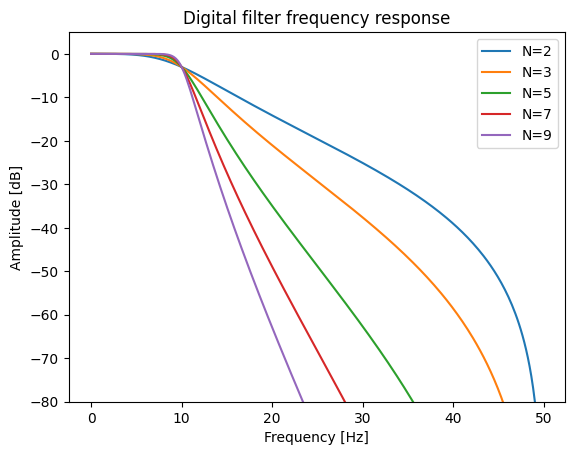

In [60]:
from typing import Tuple

def butterworth(N: int, fc: float, fs: float) -> Tuple[np.ndarray, np.ndarray]:
    """Return the numerator and denominator of the Butterworth filter.

    Args:
        N (int): filter order
        fc (float): cutoff frequency in Hz
        fs (float): sample frequency in Hz

    Returns:
        Tuple[np.ndarray, np.ndarray]: [b, a] the numerator and denominator coefficients
    """
    if fc >= fs / 2:
        raise ValueError("Cutoff frequency must be less than half the sample frequency.")
    # Find the poles of the analog filter
    k = np.arange(1, N + 1)
    theta =  (2 * k - 1) * np.pi / (2 * N)
    pa = -np.sin(theta) + 1j * np.cos(theta)
    # scale the poles in frequency
    Fc = fs/np.pi * np.tan(np.pi * fc / fs)
    pa = pa*2*np.pi*Fc
    # find the coefficients of the digital filter
    p = (1 + pa/(2*fs)) / (1 - pa/(2*fs))
    q = -np.ones(N)

    a = np.poly(p)
    a = np.real(a)
    b = np.poly(q)
    K = np.sum(a) / np.sum(b)
    b = b*K
    return b, a
fig, ax = plt.subplots()
for N in [2, 3, 5, 7, 9]:
    b, a = butterworth(N, 10, 100)
    w, h = signal.freqz(b, a, worN=256, fs=100)
    # convert w to Hz
    ax.plot(w, 20 * np.log10(abs(h)), label=f'N={N}')
ax.legend(loc='best')
ax.set_title('Digital filter frequency response')
ax.set_ylim(-80, 5)
ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [Hz]')
plt.show()

Lets compare our method with the results we obtain from the scipy version.

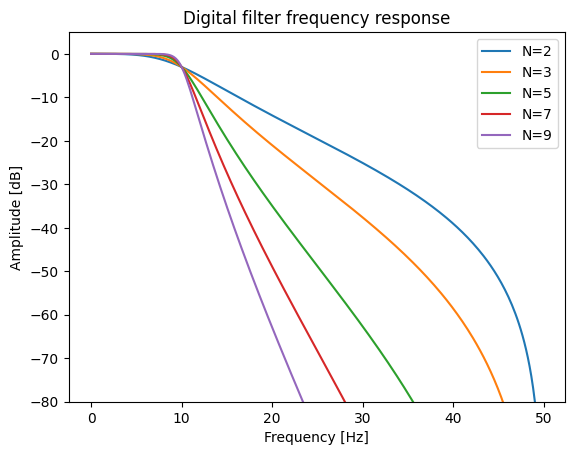

In [61]:
from scipy import signal

fig, ax = plt.subplots()
for N in [2, 3, 5, 7, 9]:
    b, a = signal.butter(N, 10, fs=100, btype="lowpass")
    w, h = signal.freqz(b, a, worN=256, fs=100)
    # convert w to Hz
    ax.plot(w, 20 * np.log10(abs(h)), label=f'N={N}')
ax.legend(loc='best')
ax.set_title('Digital filter frequency response')
ax.set_ylim(-80, 5)
ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [Hz]')
plt.show()

The results from the scipy method look identical to the results from our method.

Now we can apply the filter parameters to a signal. We will create a signal with two sinusoidal components, one at a frequency of 10Hz and the other at 20Hz. We will apply a butterworth filter with a cutoff frequency of 15Hz. We would expect this to limit the output signal to just the 10Hz component.

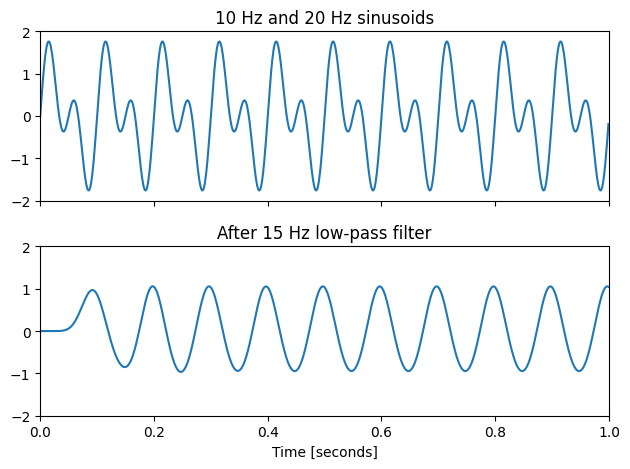

In [62]:
sample_frequency = 1000
t = np.linspace(0, 1, sample_frequency, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
# butterworth filter with a cutoff frequncy of 15Hz
b, a = butterworth(10, 15, sample_frequency)
# TODO: figure out if we should implement lfilter ourselves
filtered = signal.lfilter(b, a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz low-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()


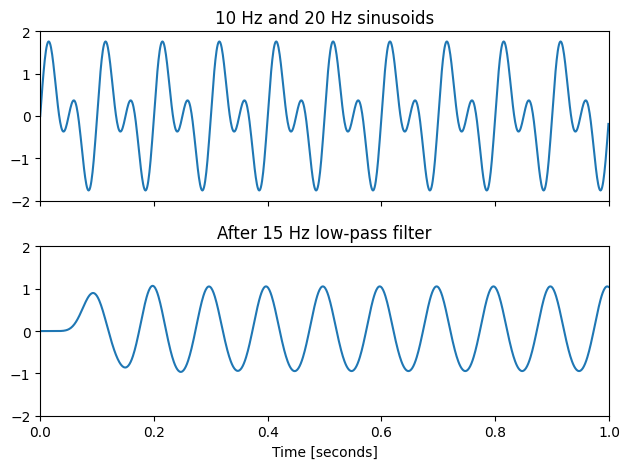

In [64]:
def iir_filter(b: np.ndarray, a: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Apply an IIR filter to a signal. The info for this function was taken from the
    notes section of the scipy.signal.lfilter documentation.

    Args:
        b (np.ndarray): numerator coefficients
        a (np.ndarray): denominator coefficients
        x (np.ndarray): input signal

    Returns:
        np.ndarray: filtered signal
    """
    # For now we will have this condition. I do not this this needs to be true generally
    if len(b) != len(a):
        raise ValueError("The numerator and denominator must have the same length.")
    y = np.zeros_like(x)
    for i in range(len(b), len(x)):
        for j in range(len(b)):
            if i - j >= 0:
                y[i] += b[j] * x[i - j]
        for j in range(1, len(a)):
            if i - j >= 0:
                y[i] -= a[j] * y[i - j]
        y[i] /= a[0]
    return y

sample_frequency = 1000
t = np.linspace(0, 1, sample_frequency, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
# butterworth filter with a cutoff frequncy of 15Hz
b, a = butterworth(10, 15, sample_frequency)
# TODO: figure out if we should implement lfilter ourselves
filtered = iir_filter(b, a, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz low-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

This seems to be working as we would expect. Now we can experiment with converting our butterworth filter into a high-pass filter.

In [10]:
from typing import List
ALICE, BOB = 0, 1
ANNOTATION_DESC_2_EVENT_ID = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

EVENT_ID = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

def fetch_epochs(subjects: List[int]) -> List[mne.Epochs]:
    user_files = fetch_data(subjects=subjects, recording=[1])
    epochs_list: List[mne.Epochs] = []
    for user_file in user_files:
        raw = mne.io.read_raw_edf(user_file[0], stim_channel='Event marker',
                                        misc=['Temp rectal'])
        annot = mne.read_annotations(user_file[1])
        raw.set_annotations(annot, emit_warning=True)
        # keep last 30-min wake events before sleep and first 30-min wake events after
        # sleep and redefine annotations on raw data
        annot.crop(annot[1]['onset'] - 30 * 60,
                        annot[-2]['onset'] + 30 * 60)
        raw.set_annotations(annot, emit_warning=False)
        events, _ = mne.events_from_annotations(
            raw, event_id=ANNOTATION_DESC_2_EVENT_ID, chunk_duration=30.)
        
        tmax = 30. - 1. / raw.info['sfreq']  # tmax in included

        epochs = mne.Epochs(raw=raw, events=events,
                                event_id=EVENT_ID, tmin=0., tmax=tmax, baseline=None)
        epochs_list.append(epochs)
    return epochs_list



In [22]:
[epochs_train, epochs_test] = fetch_epochs([ALICE, BOB])
# epochs.shape = (n_epochs, n_channels, n_times)
# n_ephochs = the number of 30-second epochs in the data
# n_channels = the number of channesl (e.g. EEG, EOG, EMG)
# n_times = the number of time points in each epoch

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/derekjohnson/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/xt/9mglw7t50vxg54jk3lcl75700000gn/T/ipykernel_14046/2681637432.py:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /Users/derekjohnson/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/xt/9mglw7t50vxg54jk3lcl75700000gn/T/ipykernel_14046/2681637432.py:23: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot, emit_warning=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


NameError: name 'epocks_train' is not defined

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Av

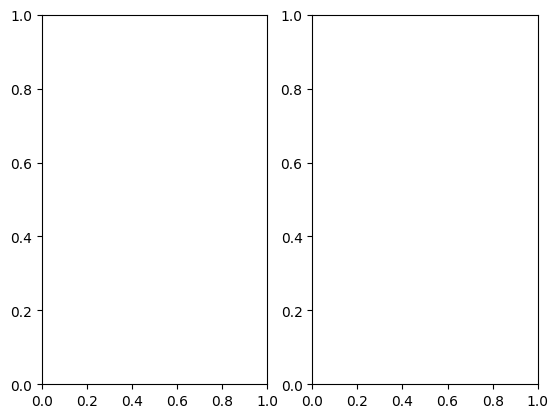

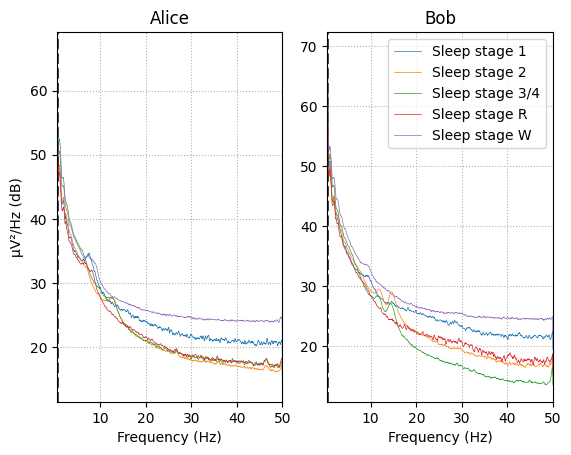

In [25]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
stages = sorted(EVENT_ID.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        # getting all of the epochs of the specified stage and computing the PSD
        spectrum = epochs[stage].compute_psd(picks='eeg', fmin=0.5, fmax=50.)
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [5]:
from sklearn.preprocessing import FunctionTransformer

def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}
    # picks limits the channels to only eeg ones
    # fmin and fmax define the frequency range of interest
    # epochs.shape = (n_epochs, n_channels, n_times)
    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.)
    # spectrum.shape = (n_epochs, n_channels - (non eeg chanels), n_freqs)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # psds.shape = spectrum.shap, freqs.shape = (n_freqs,)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

funct_transformer = FunctionTransformer(eeg_power_band, validate=False)

In [13]:
X = funct_transformer.transform(epochs_train.copy())
print(X.shape)

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
(841, 25)
